t = 1 is done!
t = 2 is done!
t = 3 is done!
t = 4 is done!
t = 5 is done!
t = 6 is done!
t = 7 is done!
t = 8 is done!
t = 9 is done!
t = 10 is done!
t = 11 is done!
t = 12 is done!
t = 13 is done!
t = 14 is done!
t = 15 is done!
t = 16 is done!
t = 17 is done!
t = 18 is done!
t = 19 is done!
t = 20 is done!
t = 21 is done!
t = 22 is done!
t = 23 is done!
t = 24 is done!
t = 25 is done!


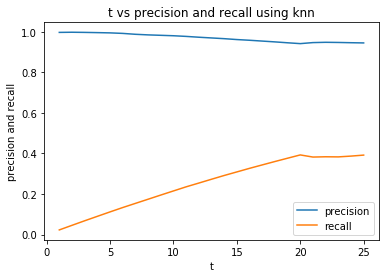

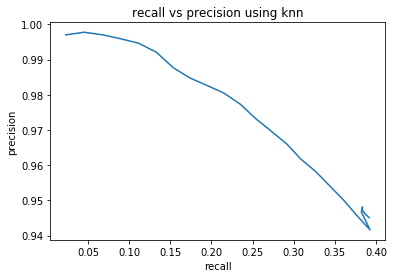

In [1]:
# Part 8
# Q36 KNN
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

# a class that stores ratings for one user
class user_rating:
    def __init__(self, userid, movies, ratings):
        self.userid = userid # a int number
        self.movies = movies # a string list
        self.avg = np.mean(ratings) # a float number
        self.ratings = dict(zip(movies, ratings)) # a dictionary mapping ratings to movies
        G = set() # movies the user likes
        for key, val in self.ratings.items():
            if val >= 3:
                G.add(key)
        self.G = G
                
    def display(self):
        print (self.userid)
        print (self.ratings)
        print (self.G)

# calculate Pearson-correlation coefficient      
def pearson(u, v):
    I = list(set(u.movies)&set(v.movies))
    if not I:
        return 0
    else:
        uk = []
        vk = []
        for id in I:
            uk.append(u.ratings[id])
            vk.append(v.ratings[id])
        uk = np.asarray(uk)
        vk = np.asarray(vk)
        uk -= u.avg
        vk -= v.avg
        tmp1 = np.sum(uk*vk)
        tmp2 = np.sqrt(np.sum(np.square(uk)))
        tmp3 = np.sqrt(np.sum(np.square(vk)))
        p = tmp1/(tmp2*tmp3+1e-9) # to avoid division by zero
        return p

# predict movie ratings of users in testset using information from trainset        
def knn(trainset, testset, k):
    res = []
    for user_test in testset:
        p = []
        for user_train in trainset:
            p.append(pearson(user_test, user_train))
        idx = np.argsort(p)[::-1][:k]
        topk = []
        for i in range(k):
            topk.append(trainset[idx[i]])
        sum = 0
        for i in idx:
            sum += abs(p[i])
        pred = []
        for movie in user_test.movies:
            tmp = user_test.avg
            for user in topk:
                if movie in user.movies:
                    tmp += pearson(user_test, user)*(user.ratings[movie]-user.avg)/sum
            pred.append(tmp)
        res.append(dict(zip(user_test.movies, pred)))
    return res

# give top t movies
def rank(pred, t):
    movies = list(pred.keys())
    ratings = list(pred.values())
    idx = np.argsort(ratings)[::-1][:t]
    recommend = []
    for i in range(t):
        recommend.append(movies[idx[i]])
    return recommend

# cross validation to get precision and recall given a spceific t
def rank_t(users, t):
    num_folds = 10
    folds = []
    precision_folds = []
    recall_folds = []
    for i in range(num_folds):
        folds.append(users[int(i*len(users)/num_folds):int((i+1)*len(users)/num_folds)])
    for i in range(num_folds):
        testset = folds[i]
        trainset = []
        for j in range(num_folds):
            if j != i:
                trainset.extend(folds[j])
        res = knn(trainset, testset, k = 30)
        precision = 0
        recall = 0
        size = len(testset)
        for k in range(size):        
            G = testset[k].G
            if len(testset[k].movies) < t or not G:
                size -= 1
                continue
            else:
                S = set(rank(res[k], t))
                I = S&G
                precision += len(I)/len(S)
                recall += len(I)/len(G)
        if size:
            precision_folds.append(precision/size)
            recall_folds.append(recall/size)
        else:
            continue
    precision_t = np.mean(precision_folds)
    recall_t = np.mean(recall_folds)
    print ('t = ' + str(t) + ' is done!')
    return precision_t, recall_t

# create a list that contains 671 user_rating objects
data = []    
with open('ratings.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        if row[0] != 'userId':
            data.append((int(row[0]), row[1], float(row[2])))
data.append((0,0,0)) # a dummy data point to avoid index out of bounds
users = []
pointer = 0
for id in range(1, 672):
    movies = []
    ratings = []
    flag = 1
    while flag:
        if data[pointer][0] == id:
            movies.append(data[pointer][1])
            ratings.append(data[pointer][2])
        if data[pointer+1][0] == id:
            pointer += 1
        else:
            flag = 0
    users.append(user_rating(id, movies, ratings))

# test on different t
ts = list(range(1, 26))
precision_knn = []
recall_knn = []
for t in ts:
    p, r = rank_t(users, t)
    precision_knn.append(p)
    recall_knn.append(r)
plt.plot(ts, precision_knn, ts, recall_knn)
plt.xlabel('t')
plt.ylabel('precision and recall')
plt.title('t vs precision and recall using knn')
plt.legend(['precision', 'recall'])
plt.show()
plt.plot(recall_knn, precision_knn)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('recall vs precision using knn')

plt.show() 

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import Dataset
from surprise import Reader

def read_data(filename):
    df = pd.read_csv(filename, delimiter=',')
    return df

def process_prediction(pred, t, threshold):
    pred_likes = {}
    for p in pred:
        if p.uid not in pred_likes.keys():
            pred_likes[p.uid] = [[p.iid, p.r_ui, p.est]]
        else:
            pred_likes[p.uid].append([p.iid, p.r_ui, p.est])
    
    precisoin = []
    recall = []
    for user in pred_likes:
        if len(pred_likes[user]) < t: 
            continue
        iid_rui_est = np.array(pred_likes[user])
        S_t = iid_rui_est[iid_rui_est[:,2].argsort()[::-1]][:,0][0:t]
        G = [data[0] for data in iid_rui_est if data[1] >= threshold]
        GS = np.intersect1d(S_t, G)
        if len(G) <= 0:
            continue
        precision.append(float(len(GS))/len(S_t))
        recall.append(float(len(GS))/len(G))
    return np.mean(precision), np.mean(recall)

ratings = read_data('ratings.csv')

For 1 : 
Precision :  0.9279356656458719
Recall :  0.2194355266901594
For 2 : 
Precision :  0.9156973492417492
Recall :  0.3514311084239487
For 3 : 
Precision :  0.9119215808219268
Recall :  0.4176418667006948
For 4 : 
Precision :  0.9110877506489321
Recall :  0.4574879944968937
For 5 : 
Precision :  0.9108872389134404
Recall :  0.48348046769693465
For 6 : 
Precision :  0.9113376697892059
Recall :  0.5012367785049063
For 7 : 
Precision :  0.9094761954325816
Recall :  0.5175955754949021
For 8 : 
Precision :  0.9049908863368831
Recall :  0.525406143335782
For 9 : 
Precision :  0.9043968728568618
Recall :  0.5378772976455035
For 10 : 
Precision :  0.9013537283803984
Recall :  0.5475969650570712
For 11 : 
Precision :  0.8994099389327855
Recall :  0.5592448086531743
For 12 : 
Precision :  0.897511182015498
Recall :  0.5693472572934944
For 13 : 
Precision :  0.8972330522614819
Recall :  0.5803312923678545
For 14 : 
Precision :  0.8947183269536835
Recall :  0.591099170996856
For 15 : 
Precisi

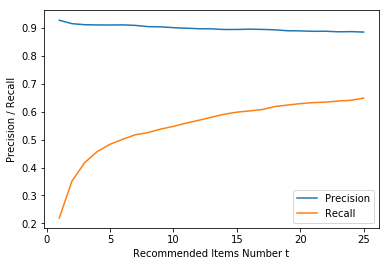

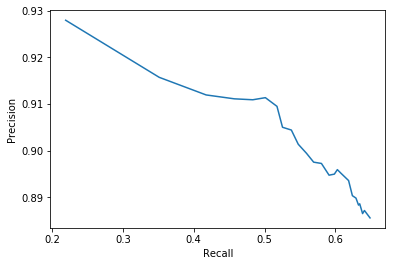

In [3]:
# Q37 NMF
# Generate the dictionary of User -> Liked Movies
from surprise.model_selection import train_test_split
reader = Reader(rating_scale=(0.0, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
precision_nmf = []
recall_nmf = []
reco_num = range(1, 26)

for t in reco_num:
    kf = KFold(n_splits=10, random_state=42)
    nmf = NMF(n_factors=20, random_state=42)
    precision = []
    recall = []
    for trainset, testset in kf.split(data):
        nmf.fit(trainset)
        pred = nmf.test(testset)
        r1, r2 = process_prediction(pred, t, 3)
        precision.append(r1)
        recall.append(r2)
    precision_nmf.append(np.mean(precision))
    recall_nmf.append(np.mean(recall))
    print ('For %i : ' %t)
    print ('Precision : ', precision_nmf[t-1])
    print ('Recall : ', recall_nmf[t-1])
    
plt.plot(reco_num, precision_nmf)
plt.plot(reco_num, recall_nmf)
plt.legend(['Precision', 'Recall'])
plt.xlabel('Recommended Items Number t')
plt.ylabel('Precision / Recall')
plt.show()

plt.plot(recall_nmf, precision_nmf) 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

For 1 : 
Precision :  0.9375171122043955
Recall :  0.22129770228002538
For 2 : 
Precision :  0.9238870709532286
Recall :  0.3527649013772722
For 3 : 
Precision :  0.9193085193980951
Recall :  0.41927070234998826
For 4 : 
Precision :  0.9197381629268657
Recall :  0.4604143125481774
For 5 : 
Precision :  0.9183792913207669
Recall :  0.4858628868997557
For 6 : 
Precision :  0.9185705534028995
Recall :  0.5036452889975696
For 7 : 
Precision :  0.9177954943674641
Recall :  0.5210508616789753
For 8 : 
Precision :  0.9144828867075451
Recall :  0.5291886229338391
For 9 : 
Precision :  0.9141995321689308
Recall :  0.5429856571428815
For 10 : 
Precision :  0.9110011622219467
Recall :  0.5528986518357819
For 11 : 
Precision :  0.9090521774155853
Recall :  0.5650404179877825
For 12 : 
Precision :  0.9065721576436381
Recall :  0.5746679989185669
For 13 : 
Precision :  0.9056807937765423
Recall :  0.5848791477036878
For 14 : 
Precision :  0.903349728050507
Recall :  0.5960457424767143
For 15 : 
Prec

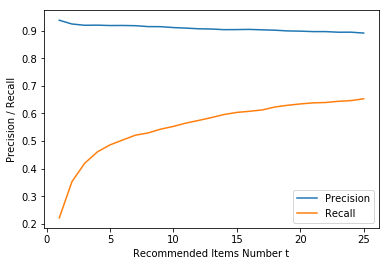

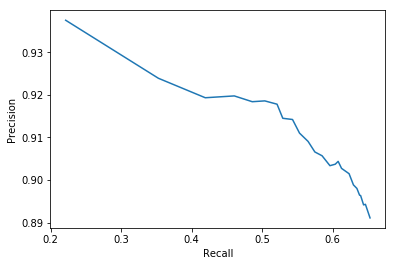

In [4]:
# Q38 MF with bias
from surprise.prediction_algorithms.matrix_factorization import SVD
precision_svd = []
recall_svd = []
reco_num = range(1, 26)

for t in reco_num:
    kf = KFold(n_splits=10, random_state=42)
    precision = []
    recall = []
    svd = SVD(n_factors=18, random_state=42)
    for trainset, testset in kf.split(data):
        svd.fit(trainset)
        pred = svd.test(testset)
        r1, r2 = process_prediction(pred, t, 3)
        precision.append(r1)
        recall.append(r2)
    precision_svd.append(np.mean(precision))
    recall_svd.append(np.mean(recall))
    print ('For %i : ' %t)
    print ('Precision : ', precision_svd[t-1])
    print ('Recall : ', recall_svd[t-1])
    
plt.plot(reco_num, precision_svd)
plt.plot(reco_num, recall_svd)
plt.legend(['Precision', 'Recall'])
plt.xlabel('Recommended Items Number t')
plt.ylabel('Precision / Recall')
plt.show()

plt.plot(recall_svd, precision_svd) 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

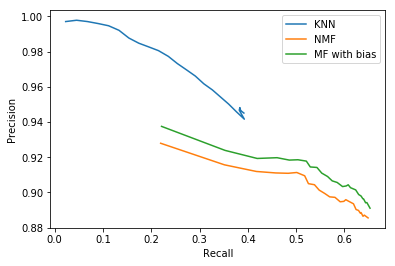

In [5]:
# Q39
plt.plot(recall_knn, precision_knn)
plt.plot(recall_nmf, precision_nmf)
plt.plot(recall_svd, precision_svd)

plt.legend(['KNN','NMF', 'MF with bias'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()